In [1]:
'''
This file plots CMIP5 RCP - HIST over South Australia
/Users/earl/Desktop/Yang
and places the outputs in
/Users/earl/Dropbox/CMIP5/figures

Earl Duran 
created: 19-Mar-18
e.duran@unsw.edu.au
'''

import cosima_cookbook as cc
import os
import xarray as xr
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import sys
import pickle
import itertools
def find_nearest_index(array, value):
    return int((np.abs(array - value)).argmin())
from scipy import interpolate
from scipy import stats
from dask.distributed import Client
import xrscipy

import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

session = cc.database.create_session()

ModuleNotFoundError: No module named 'xrscipy'

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
client = Client()
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:34475 Dashboard: http://127.0.0.1:45073/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [4]:
input_path = '/g/data/e14/erd561/copernicus/'

output_path = '/g/data/e14/erd561/Australia_2004-2017/'

In [5]:
data = xr.open_dataset(input_path + 'dataset-sss-ssd-rep-monthly_1569548439236.nc')
data

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 360, lon: 361, time: 300)
Coordinates:
  * depth    (depth) float32 0.0
  * lon      (lon) float32 89.875 90.125 90.375 ... 179.375 179.625 179.875
  * time     (time) object 1993-01-15 00:00:00 ... 2017-12-15 00:00:00
  * lat      (lat) float32 -69.875 -69.625 -69.375 ... 19.375 19.625 19.875
Data variables:
    sos      (time, depth, lat, lon) float32 ...
Attributes:
    Conventions:                                CF-1.7
    references:                                 Buongiorno Nardelli, B., R. D...
    institution:                                CNR
    contact:                                    servicedesk.cmems@mercator-oc...
    FROM_ORIGINAL_FILE__netcdf_version_id:      4.4.1 of Aug 10 2016 17:24:31 
    creation_date:                              Wed 17 Jul 2019 22:20:07
    FROM_ORIGINAL_FILE__product_version:        1.0
    grid_resolution:                            0.25 degrees
    FROM_ORIGINAL_FILE__software_version:       

In [6]:
year = np.arange(2004,2018)

lonW = 88
lonE = 182

latS = -72
latN = 22

salt_z0_month = xr.open_dataset(input_path + 'dataset-sss-ssd-rep-monthly_1569548439236.nc').\
                                sos.\
                sel(lon=slice(lonW,lonE)).\
                sel(lat=slice(latS,latN)).\
                sel(depth=0, method='nearest')
print(salt_z0_month)

salt_z0 = salt_z0_month.\
                groupby('time.year').\
                mean('time')
print(salt_z0)

salt_z0 = salt_z0.sel(year=slice(2004,2017))
print(salt_z0)

<xarray.DataArray 'sos' (time: 300, lat: 360, lon: 361)>
[38988000 values with dtype=float32]
Coordinates:
    depth    float32 0.0
  * lon      (lon) float32 89.875 90.125 90.375 ... 179.375 179.625 179.875
  * time     (time) object 1993-01-15 00:00:00 ... 2017-12-15 00:00:00
  * lat      (lat) float32 -69.875 -69.625 -69.375 ... 19.375 19.625 19.875
Attributes:
    long_name:      sea surface salinity
    standard_name:  sea_surface_salinity
    units:          .0001
    _ChunkSizes:    [   1    1  720 1440]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sos' (year: 25, lat: 360, lon: 361)>
array([[[      nan,       nan,       nan, ..., 34.028866, 34.02695 ,
         34.025105],
        [      nan,       nan,       nan, ..., 34.011803, 34.01018 ,
         34.00929 ],
        [      nan,       nan,       nan, ..., 34.004814, 34.0034  ,
         34.002956],
        ...,
        [30.701935, 30.670694, 30.658201, ..., 35.02671 , 35.027878,
         35.023666],
        [30.543642, 30.53934 , 30.497835, ..., 35.048077, 35.046772,
         35.045788],
        [30.377783, 30.361895, 30.331146, ..., 35.070217, 35.066364,
         35.068134]],

       [[      nan,       nan,       nan, ..., 34.03025 , 34.029293,
         34.027363],
        [      nan,       nan,       nan, ..., 34.01235 , 34.011307,
         34.009995],
        [      nan,       nan,       nan, ..., 34.005722, 34.00488 ,
         34.003532],
        ...,
        [30.707014, 30.66664 , 30.647789, ..., 35.029514, 35.029636,
         35.02525 ],
        [30.5255

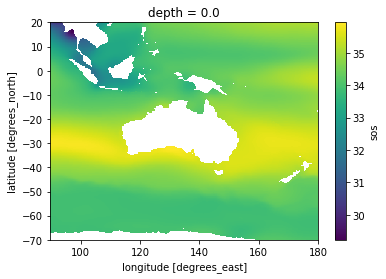

In [7]:
salt_z0.mean('year').plot()

In [8]:
lat = salt_z0.lat
lon = salt_z0.lon

# salt_z0_trans = salt_z0.transpose('LATITUDE', 'LONGITUDE', 'year')
salt_z0_trans = salt_z0
print(np.shape(salt_z0_trans))
salt_z0_slope = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), dims=(
    'lat', 'lon'), coords=[lat, lon], name='salt_z0')
print(np.shape(salt_z0_slope))
salt_z0_p_value = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), dims=(
    'lat', 'lon'), coords=[lat, lon], name='salt_z0')
salt_z0_std_err = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), dims=(
    'lat', 'lon'), coords=[lat, lon], name='salt_z0')
for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):
        salt_z0_slope[iid, jid], _, _, salt_z0_p_value[iid, jid], salt_z0_std_err[iid, jid] = \
        stats.linregress(year, salt_z0_trans[:, iid, jid])
    print('lat ' + str(np.array(i)))
print(salt_z0_slope)

(14, 360, 361)
(360, 361)
lat -69.875
lat -69.625
lat -69.375
lat -69.125
lat -68.875
lat -68.625
lat -68.375
lat -68.125
lat -67.875
lat -67.625
lat -67.375
lat -67.125
lat -66.875
lat -66.625
lat -66.375
lat -66.125
lat -65.875
lat -65.625
lat -65.375
lat -65.125
lat -64.875
lat -64.625
lat -64.375
lat -64.125
lat -63.875
lat -63.625
lat -63.375
lat -63.125
lat -62.875
lat -62.625
lat -62.375
lat -62.125
lat -61.875
lat -61.625
lat -61.375
lat -61.125
lat -60.875
lat -60.625
lat -60.375
lat -60.125
lat -59.875
lat -59.625
lat -59.375
lat -59.125
lat -58.875
lat -58.625
lat -58.375
lat -58.125
lat -57.875
lat -57.625
lat -57.375
lat -57.125
lat -56.875
lat -56.625
lat -56.375
lat -56.125
lat -55.875
lat -55.625
lat -55.375
lat -55.125
lat -54.875
lat -54.625
lat -54.375
lat -54.125
lat -53.875
lat -53.625
lat -53.375
lat -53.125
lat -52.875
lat -52.625
lat -52.375
lat -52.125
lat -51.875
lat -51.625
lat -51.375
lat -51.125
lat -50.875
lat -50.625
lat -50.375
lat -50.125
lat -49.875
la

In [10]:
salt_z0_xr = xr.DataArray(np.transpose(salt_z0.values, (1,2,0)), name='salt_z0_cmems',
                        coords=[lat, lon, year], 
                        dims=['lat', 'lon', 'year'])
print(salt_z0_xr)
salt_z0_xr.to_netcdf(output_path + 'salt_z0_cmems.nc')

salt_z0_slope_xr = xr.DataArray(salt_z0_slope, name='salt_z0_slope_cmems',
                        coords=[lat, lon], 
                        dims=['lat', 'lon'])
print(salt_z0_slope_xr)
salt_z0_slope_xr.to_netcdf(output_path + 'salt_z0_slope_cmems.nc')

salt_z0_p_value_xr = xr.DataArray(salt_z0_p_value, name='salt_z0_p_value_cmems',
                        coords=[lat, lon], 
                        dims=['lat', 'lon'])
print(salt_z0_p_value_xr)
salt_z0_p_value_xr.to_netcdf(output_path + 'salt_z0_p_value_cmems.nc')

salt_z0_std_err_xr = xr.DataArray(salt_z0_std_err, name='salt_z0_std_err_cmems',
                        coords=[lat, lon], 
                        dims=['lat', 'lon'])
print(salt_z0_std_err_xr)
salt_z0_std_err_xr.to_netcdf(output_path + 'salt_z0_std_err_cmems.nc')

<xarray.DataArray 'salt_z0_cmems' (lat: 360, lon: 361, year: 14)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [34.022358, 34.027264, 34.029488, ..., 34.031345, 34.029476,
         34.0085  ],
        [34.020252, 34.026386, 34.028183, ..., 34.030334, 34.027325,
         34.008205],
        [34.01932 , 34.02502 , 34.026615, ..., 34.02855 , 34.026196,
         34.008354]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [34.00692 , 34.010498, 34.011456, ..., 34.0141  , 34.01307 ,
         33.99551 ],
      